In [1]:
import sys
import torch
from matplotlib import pyplot as plt
import numpy as np
import os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP

from positional_encoders import generate_positional_encoding
from plotters import *

/home/yigit/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
batch_size = 1
device = torch.device("cpu")

root_path = '/home/yigit/projects/pemp/outputs/'
test_path = 'xarm/bare_pe/1758717282/'

folder_path = root_path + test_path

y_train = torch.load(folder_path+'y.pt', map_location='cpu').to('cpu')
y_test = torch.load(folder_path+'y_test.pt', map_location='cpu').to('cpu')
x_train = torch.load(folder_path+'x.pt', map_location='cpu').to('cpu')
x_test = torch.load(folder_path+'x_test.pt', map_location='cpu').to('cpu')
g_train = torch.load(folder_path+'g.pt', map_location='cpu').to('cpu')
g_test = torch.load(folder_path+'g_test.pt', map_location='cpu').to('cpu')

num_demos, t_steps, dy = y_train.shape
num_test = y_test.shape[0]
num_trajs = num_demos + num_test
dx, dg, dpe = 1, 1, 27
n_max, m_max = 20, 20
max_freq = torch.max(g_train).item()
min_freq = torch.min(g_train).item()
max_freq = round(max_freq/min_freq)
pe = generate_positional_encoding(t_steps, dpe)

Y = torch.cat([y_train, y_test], dim=0).numpy()
x = torch.cat([x_train, x_test], dim=0).numpy()

In [3]:
models_folder = folder_path + 'saved_models/'
bare_path = models_folder + 'bare.pt'
pemp_path = models_folder + 'pe.pt'

enc_dims = [256,256,256]
dec_dims = [256,256,256]

bare = CNMP(input_dim=dx+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
pemp = CNMP(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)

bare.load_state_dict(torch.load(bare_path, map_location=device))
pemp.load_state_dict(torch.load(pemp_path, map_location=device))

<All keys matched successfully>

In [4]:
# Plotting parameters
colors = ['#377eb8', '#e41a1c', '#ff7f00', '#f781bf', '#4daf4a', '#a65628', '#984ea3', '#999999', '#dede00']
linestyles = [(0, (3, 1, 1, 1, 1, 1)), (0, (1, 1)), '--', (0, (5, 10)), ':', '-.', '-', (0, (1, 3))]

promp_index = 0
bare_index = 1
pemp_index = 2

labels = ['ProMP', 'CNMP', 'PEMP']
num_models = len(labels)

In [5]:
bare_obs = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
bare_tar_x = torch.zeros((batch_size, t_steps, dx+dg), dtype=torch.float32, device=device)

pemp_obs = torch.zeros((batch_size, n_max, dpe+dg+dy), dtype=torch.float32, device=device)
pemp_tar_x = torch.zeros((batch_size, t_steps, dpe+dg), dtype=torch.float32, device=device)

obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

n = np.random.randint(0, n_max)

bare_obs.fill_(0)
bare_tar_x.fill_(0)
pemp_obs.fill_(0)
pemp_tar_x.fill_(0)
obs_mask.fill_(False)

obs_mask[0, :n] = True

bare_tar_x[0, :, :dx] = torch.linspace(0, 1, t_steps).unsqueeze(1)
pemp_tar_x[0, :, :dpe] = pe

In [6]:
test_traj_ind = np.random.randint(0, num_test)
test_x_inds = np.random.randint(0, t_steps, n)
test_ys = y_test[test_traj_ind, test_x_inds] + torch.from_numpy(np.random.normal(0, 0.01, (n, dy)))
test_g = g_test[test_traj_ind].item()

In [7]:
for i in range(n):
    test_x_ind = test_x_inds[i]
    test_y = test_ys[i]
    bare_obs[0, i, :dx] = x_test[test_traj_ind, test_x_ind]
    bare_obs[0, i, dx:dx+dg] = test_g #g_test[test_x_ind]
    bare_obs[0, i, dx+dg:] = test_y

    pemp_obs[0, i, :dpe] = pe[test_x_ind]
    pemp_obs[0, i, dpe:dpe+dg] = test_g #g_test[test_x_ind]
    pemp_obs[0, i, dpe+dg:] = test_y
bare_tar_x[0, :, dx:] = test_g
pemp_tar_x[0, :, dpe:] = test_g

bare_trajectory = bare.val(bare_obs, bare_tar_x, obs_mask)[:, :, :dy] * np.pi*2
pemp_trajectory = pemp.val(pemp_obs, pemp_tar_x, obs_mask)[:, :, :dy] * np.pi*2

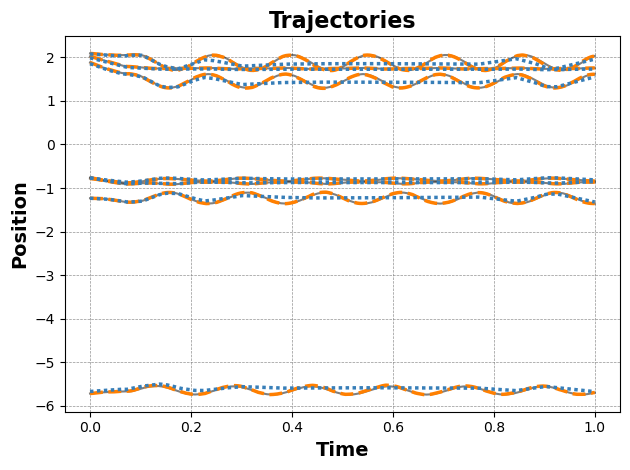

In [8]:
plt.plot(x_test[0], y_test[test_traj_ind].cpu().numpy()*2*np.pi, color='black', label='Ground truth', alpha=0.5)
# min_dist_ind = np.argmin(promp_dists)
# for i in range(num_promps):
#     plt.plot(x_test[0], promp_trajs[i], color=colors[promp_index], linestyle=linestyles[promp_index], alpha=(np.min(promp_dists)/promp_dists[i])**10, label='ProMP prediction' if i==min_dist_ind else '')

for i in range(n):
    test_x_ind = test_x_inds[i]
    test_y = test_ys[i]
    cond_point = np.array([test_y])
    t = x_test[test_traj_ind, test_x_ind].item()*t_steps
    # plt.scatter(t/t_steps, cond_point, color='black', s=80, label='Condition points' if i==0 else '')

plt.title("Trajectories", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=14, fontweight='bold')
plt.ylabel("Position", fontsize=14, fontweight='bold')
plt.ylim = (-1.0, 1.0)
plt.plot(x_test[0], pemp_trajectory[0].cpu().detach().numpy(), color=colors[pemp_index], linestyle=linestyles[pemp_index], linewidth=2.5, label='PEMP')
plt.plot(x_test[0], bare_trajectory[0].cpu().detach().numpy(), color=colors[0], linestyle=linestyles[bare_index], linewidth=2.5, label='CNMP')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.85)
# plt.legend(loc='best', frameon=True, framealpha=0.75, fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
ptj = pemp_trajectory.numpy()
btj = bare_trajectory.numpy()
gen_path = folder_path + 'gen/'

if not os.path.exists(gen_path):
    os.makedirs(gen_path)

np.save(gen_path+'pemp_t.npy', ptj)
np.save(gen_path+'bare_t.npy', btj)

#### RUNNING TRAJECTORY ON ROBOT

In [28]:
import time
from xarm.wrapper import XArmAPI

ROBOT_IP        = '192.168.1.225'
TRAJ_PATH       = gen_path+'pemp_t.npy'       # 1x400x7 or 400x7
SERVO_RATE_HZ   = 100.0              # 50–200 Hz typical
TOTAL_TIME_S    = 8.0                # duration to play the whole trajectory (tune)
RAMP_TIME_S     = 1.0                # gentle ramp from current -> first waypoint

def load_traj(path):
    T = np.load(path)
    if T.ndim == 3 and T.shape[0] == 1:
        T = T[0]
    if T.shape[-1] != 7:
        raise ValueError(f'Expected last dim = 7, got {T.shape}')
    return T  # shape (N,7) in radians

def cubic_upsample(W, rate_hz, total_time_s):
    """Upsample a (N,7) waypoints array to fixed dt using cubic interpolation."""
    N = len(W)
    tq = np.linspace(0.0, 1.0, N)
    M = max(2, int(total_time_s * rate_hz))
    t  = np.linspace(0.0, 1.0, M)
    # per-joint cubic (fall back to linear if N<4)
    if N >= 4:
        from scipy.interpolate import CubicSpline  # optional; if missing, we do linear
        out = np.empty((M, 7), dtype=float)
        for j in range(7):
            out[:, j] = CubicSpline(tq, W[:, j], bc_type='clamped')(t)
        return out
    else:
        # linear fallback
        return np.stack([np.interp(t, tq, W[:, j]) for j in range(7)], axis=1)

def rad_clamp(q):
    """Basic clamp to [-pi, pi] for wrist roll etc. Remove if your limits differ."""
    q = np.asarray(q)
    q = (q + np.pi) % (2*np.pi) - np.pi
    return q

def move_home(arm):
    # Move to home position
    arm.set_position(x=470, y=0, z=425, roll=180, pitch=0, yaw=0, speed=50, is_radian=False)

def move_center(arm):
    # Move to center position
    arm.set_position(x=470, y=0, z=310, roll=180, pitch=0, yaw=0, speed=50, is_radian=False)

def wrap_up(arm):
    move_center(arm)
    move_home(arm)
    arm.disconnect()

In [ ]:
arm = XArmAPI(ROBOT_IP, is_radian=True)  # use radians end-to-end
arm.motion_enable(True)
arm.set_mode(0); arm.set_state(0)

W = load_traj(TRAJ_PATH)              # (N,7) in radians
W_up = cubic_upsample(W, SERVO_RATE_HZ, TOTAL_TIME_S)

curr = np.array(arm.angles)
goal0 = np.array(W_up[0])
ramp_M = max(2, int(RAMP_TIME_S * SERVO_RATE_HZ))
ramp = np.stack([np.linspace(curr[j], goal0[j], ramp_M) for j in range(7)], axis=1)

# ------------------------
# Start servo-joint streaming
# ------------------------
#arm.set_mode(1); arm.set_state(0)      # servo mode for streaming

ROBOT_IP: 192.168.1.225, VERSION: v2.4.0, PROTOCOL: V1, DETAIL: 7,7,XS1304,AC1303,v2.4.0, TYPE1300: [1, 1]
change protocol identifier to 3


ControllerError, code: 1
[SDK][ERROR][2025-10-01 23:35:49][base.py:1216] - - client timeout over 90s, disconnect


In [ ]:
def stream_segment(seg):
    dt = 1.0 / SERVO_RATE_HZ
    t0 = time.time()
    for k in range(len(seg)):
        q = seg[k].tolist()  # 7 elems, radians
        arm.set_servo_angle(angle=q, is_radian=True, speed=100, wait=False)

        t_next = t0 + (k+1)*dt
        while time.time() < t_next:
            time.sleep(0.0005)

move_home(arm)
# time.sleep(4.0)
# try:
#     # 1) gentle ramp
#     stream_segment(ramp)
#     # 2) play the upsampled trajectory
stream_segment(W_up)
# finally:
#     # return to planner mode if you want to do other moves
#     # arm.set_mode(0); arm.set_state(0)
#     # wrap_up(arm)
#     asdad=1

[SDK][ERROR][2025-10-01 18:57:23][base.py:168] - - [report-socket] socket read timeout
[SDK][ERROR][2025-10-01 18:57:23][base.py:168] - - [report-socket] socket read timeout
[SDK][ERROR][2025-10-01 18:57:23][base.py:168] - - [report-socket] socket read timeout


In [27]:
# arm.set_state(0)
# arm.set_mode(0)
move_home(arm)
# time.sleep(4.0)
# for i in range(len(W_up)):
#     arm.set_servo_angle(angle=W_up[i].tolist(), is_radian=True, wait=False)

In [14]:
print(W_up.shape)
print(W_up[2])
print(np.array(arm.angles))
print('mode=', arm.mode, 'state=', arm.state)

(800, 7)
[ 2.09026398 -0.76524938 -1.23585273  1.87359431 -0.78504407  2.01568231
 -5.72066252]
[ 2.096708 -0.74875  -1.237487  1.899869 -0.774268  2.031349 -5.727766]
mode= 1 state= 2


In [40]:
print(curr[2])
print(goal0[0])

0
2.0908384323120117
